<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Один-нейрон-на-PyTorch" data-toc-modified-id="Один-нейрон-на-PyTorch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><b>Один нейрон на PyTorch</b></a></span><ul class="toc-item"><li><span><a href="#Компоненты-нейросети" data-toc-modified-id="Компоненты-нейросети-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><b>Компоненты нейросети</b></a></span></li><li><span><a href="#Один-нейрон-на-PyTorch" data-toc-modified-id="Один-нейрон-на-PyTorch-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span><b>Один нейрон на PyTorch</b></a></span></li><li><span><a href="#Полезные-ссылки" data-toc-modified-id="Полезные-ссылки-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span><b>Полезные ссылки</b></a></span></li></ul></li></ul></div>

---

<h2 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

---

В этом ноутбуке мы научимся писать свои нейросети на фреймворке PyTorch, конкретно -- рассмотрим, как написать свой нейрон с разными функциями потерь и рассмотрим его работу на конкретных датасетах.

<h3 style="text-align: center;"><b>Компоненты нейросети</b></h3>

Здесь самое время напомнить о том, какие вещи играют принципиальную роль в построении любой ***нейронной сети*** (все их мы задаём *руками*, самостоятельно):  

- непосредственно, сама **архитектура** нейросети (сюда входят типы функций активации у каждого нейрона);
- начальная **инициализация** весов каждого слоя;
- метод **оптимизации** нейросети (сюда ещё входит метод изменения `learning_rate`);
- размер **батчей** (`batch_size`);
- количество **эпох** обучения (`num_epochs`);
- **функция потерь** (`loss`);  
- тип **регуляризации** нейросети (для каждого слоя можно свой);  

То, что связано с ***данными и задачей***:  
- само **качество** выборки (непротиворечивость, чистота, корректность постановки задачи);  
- **размер** выборки;  

<h3 style="text-align: center;"><b>Один нейрон на PyTorch</b></h3>

Данные пока что возьмём как и прежде -- "яблоки и груши":

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("./apples_pears.csv")

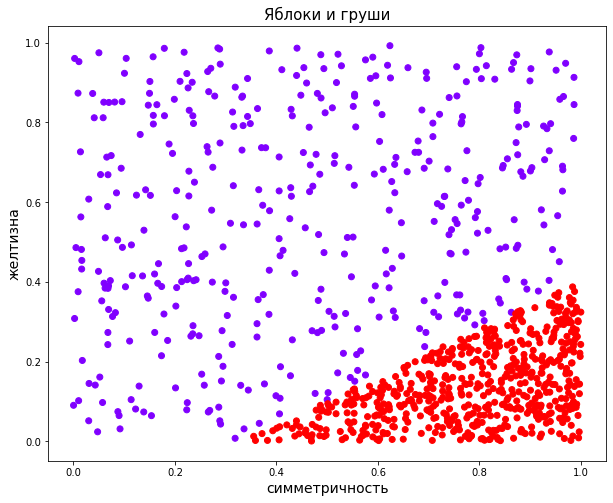

In [3]:
plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=data['target'], cmap='rainbow')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

In [4]:
X = data.iloc[:,:2].values  # матрица объекты-признаки
y = data['target'].values.reshape((-1, 1))  # классы (столбец из нулей и единиц)

В модуле torch.nn лежат все необходимые вещи для конструирования нейронок, а в модуле torch.optim лежат все необходимые вещи для выбора метода оптимизации нейросети:

In [5]:
import torch
from torch.nn import Linear, Sigmoid

Есть **два пути объявления нейросетей** в PyTorch:  
- ***функциональный (`Functional`);***
- ***последовательный (`Sequential`);***

Рассмотрим второй путь (он чуть более user-friendly) и построим таким способом один нейрон (точно такой же, который мы реализовывали раньше с помощью Numpy):

In [6]:
num_features = X.shape[1]

neuron = torch.nn.Sequential(
    Linear(num_features, out_features=1),
    Sigmoid()
)

In [7]:
neuron

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

Пока что мы просто создали объект класса `Sequential`, который состоит из одного линейного слоя размерности (num_features, 1) и последующего применения сигмоиды. Но уже сейчас его можно применить к объекту (тензору), просто веса в начале инициализирутся случайно и при forward_pass'е мы получим какой-то ответ пока что необученного нейрона:

In [8]:
neuron(torch.autograd.Variable(torch.FloatTensor([1, 1])))

tensor([0.5183], grad_fn=<SigmoidBackward0>)

Предскажем ещё необученным нейроном:

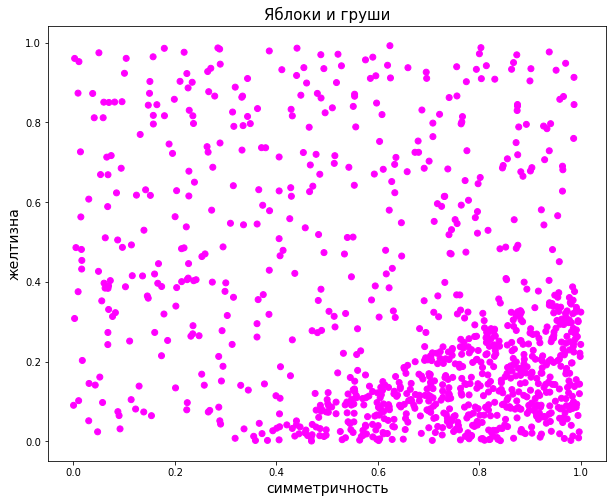

In [9]:
proba_pred = neuron(torch.autograd.Variable(torch.FloatTensor(X)))
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Как и ожидалось, ничего полезного. Давайте научим нейрон отличать груши от яблок по их симметричности и желтизне!

Обернём данные в `torch.Tensor`'ы, а тензоры в `torch.Variable`'ы, чтобы можно было вычислять градиенты по весам:

In [10]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.FloatTensor(y))

Код обучения одного нейрона на PyTorch:

In [11]:
# квадратичная функция потерь (можно сделать другую, например, LogLoss)
loss_fn = torch.nn.MSELoss(size_average=False)

# шаг градиентного спуска (точнее -- метода оптимизации)
learning_rate = 0.001  # == 1e-3
# сам метод оптимизации нейросети (обычно лучше всего по-умолчанию работает Adam)
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
# итерируемся num_epochs раз, здесь 500
for t in range(500):
    # foward_pass() -- применение нейросети (этот шаг ещё называют inference)
    y_pred = neuron(X)

    # выведем loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # обнуляем градиенты перед backard_pass'ом (обязательно!)
    optimizer.zero_grad()

    # backward_pass() -- вычисляем градиенты loss'а по параметрам (весам) нейросети
    # этой командой мы только вычисляем градиенты, но ещё не обновляем веса
    loss.backward()

    # а тут уже обновляем веса
    optimizer.step()

C:\Users\gimly\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


0 235.88584899902344
1 231.10003662109375
2 226.7808380126953
3 222.79193115234375
4 219.04373168945312
5 215.47779846191406
6 212.05636596679688
7 208.755126953125
8 205.55856323242188
9 202.45648193359375
10 199.44236755371094
11 196.5118408203125
12 193.6616973876953
13 190.8896026611328
14 188.19354248046875
15 185.57179260253906
16 183.02267456054688
17 180.54449462890625
18 178.13560485839844
19 175.7943115234375
20 173.51885986328125
21 171.3074951171875
22 169.158447265625
23 167.0699462890625
24 165.04013061523438
25 163.06729125976562
26 161.14964294433594
27 159.2854461669922
28 157.47293090820312
29 155.7104949951172
30 153.9964141845703
31 152.32916259765625
32 150.7071075439453
33 149.1287078857422
34 147.59254455566406
35 146.09713745117188
36 144.64111328125
37 143.22311401367188
38 141.84182739257812
39 140.49603271484375
40 139.18446350097656
41 137.90599060058594
42 136.6594696044922
43 135.44381713867188
44 134.25799560546875
45 133.10098266601562
46 131.97181701660

458 51.86082458496094
459 51.818939208984375
460 51.777183532714844
461 51.735565185546875
462 51.6940803527832
463 51.65272903442383
464 51.61150360107422
465 51.57041931152344
466 51.529457092285156
467 51.48863220214844
468 51.447933197021484
469 51.40736389160156
470 51.36691665649414
471 51.32660675048828
472 51.28641128540039
473 51.24635314941406
474 51.20641326904297
475 51.16660690307617
476 51.126914978027344
477 51.08735275268555
478 51.047908782958984
479 51.008583068847656
480 50.969390869140625
481 50.93031311035156
482 50.891353607177734
483 50.852516174316406
484 50.81378936767578
485 50.77519226074219
486 50.73670959472656
487 50.69834518432617
488 50.660091400146484
489 50.6219596862793
490 50.58393859863281
491 50.5460319519043
492 50.508235931396484
493 50.470558166503906
494 50.43299865722656
495 50.395538330078125
496 50.35820770263672
497 50.32097625732422
498 50.283851623535156
499 50.246849060058594


Обучили. Предскажем теперь:

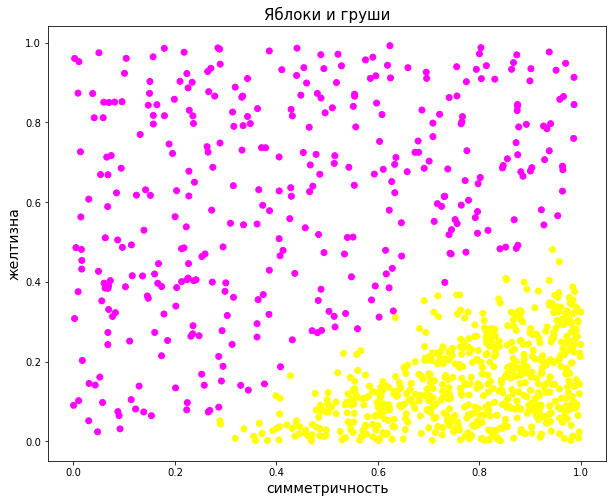

In [12]:
proba_pred = neuron(X)
y_pred = proba_pred > 0.5
y_pred = y_pred.data.numpy().reshape(-1)

plt.figure(figsize=(10, 8))
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_pred, cmap='spring')
plt.title('Яблоки и груши', fontsize=15)
plt.xlabel('симметричность', fontsize=14)
plt.ylabel('желтизна', fontsize=14)
plt.show();

Можно добиться лучшего качества работы путём изменения `learning_rate` и количества итераций (возможно, ещё функции потерь и функции активации). Рекомендуем вам поупражняться и использовать функцию потерь `torch.nn.NLLLoss()` или `torch.nn.CrossEntropy()`.

---

Нейрон работет, отличает яблоки от груш. Давайте попробуем более сложную выборку, которая уже не разделяется линейно:

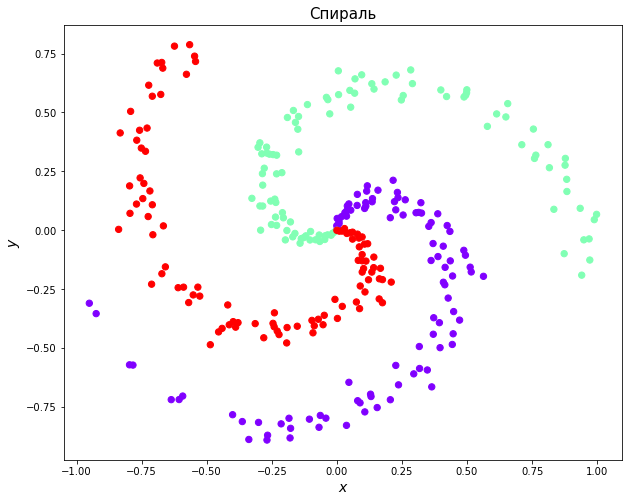

In [13]:
N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)
plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Данные в Variable():

In [14]:
X = torch.autograd.Variable(torch.FloatTensor(X))
y = torch.autograd.Variable(torch.LongTensor(y.astype(np.int64)))

In [15]:
print(X.data.shape, y.data.shape)

torch.Size([300, 2]) torch.Size([300])


Попробуем нейрон с сигмоидой на линейно неразделимой выборке (точнее в данном случае это уже 3 нейрона с софтмаксом):

In [16]:
# N - размер батча (batch_size, нужно для метода оптимизации)
# D_in - размерность входа (количество признаков у объекта)
# D_out - размерность выходного слоя (суть -- количество классов)
N, D_in, D_out = 64, 2, 3

neuron = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
)

# см. урок по многоклассовой классифкации
loss_fn = torch.nn.CrossEntropyLoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.SGD(neuron.parameters(), lr=learning_rate)
for t in range(500):
    # forward
    y_pred = neuron(X)

    # loss
    loss = loss_fn(y_pred, y)
    print('{} {}'.format(t, loss.data))

    # зануляем градиенты с предыдущего шага
    optimizer.zero_grad()

    # backward
    loss.backward()

    # обновляем веса 
    optimizer.step()

0 321.8628234863281
1 321.45880126953125
2 321.05841064453125
3 320.6615295410156
4 320.2681884765625
5 319.8783874511719
6 319.4919738769531
7 319.1090087890625
8 318.72943115234375
9 318.35321044921875
10 317.9803161621094
11 317.61065673828125
12 317.2442626953125
13 316.881103515625
14 316.5210876464844
15 316.1642150878906
16 315.8103942871094
17 315.4596862792969
18 315.1119689941406
19 314.767333984375
20 314.42559814453125
21 314.0868225097656
22 313.7508850097656
23 313.4178771972656
24 313.08770751953125
25 312.7603454589844
26 312.4356994628906
27 312.1138610839844
28 311.794677734375
29 311.4781799316406
30 311.1643981933594
31 310.85308837890625
32 310.54449462890625
33 310.2384338378906
34 309.93487548828125
35 309.63385009765625
36 309.335205078125
37 309.0390625
38 308.7453308105469
39 308.4539489746094
40 308.1649475097656
41 307.8782653808594
42 307.5939025878906
43 307.3117980957031
44 307.0319519042969
45 306.75433349609375
46 306.47894287109375
47 306.2056579589844

451 258.7577209472656
452 258.6993103027344
453 258.6409606933594
454 258.582763671875
455 258.5246887207031
456 258.4668273925781
457 258.4090270996094
458 258.35137939453125
459 258.29388427734375
460 258.236572265625
461 258.1793212890625
462 258.1221923828125
463 258.0652160644531
464 258.0084228515625
465 257.95172119140625
466 257.8951721191406
467 257.8387145996094
468 257.78240966796875
469 257.72625732421875
470 257.67022705078125
471 257.61431884765625
472 257.5585021972656
473 257.5028991699219
474 257.4473571777344
475 257.3919677734375
476 257.3367004394531
477 257.28155517578125
478 257.2265930175781
479 257.17169189453125
480 257.1169738769531
481 257.0623474121094
482 257.00787353515625
483 256.9534912109375
484 256.89923095703125
485 256.84515380859375
486 256.7911376953125
487 256.7372741699219
488 256.6835021972656
489 256.6298828125
490 256.5763854980469
491 256.52301025390625
492 256.4697570800781
493 256.4166564941406
494 256.3636169433594
495 256.31072998046875
4

In [17]:
# Обратно в Numpy для отрисовки
X = X.data.numpy()
y = y.data.numpy()

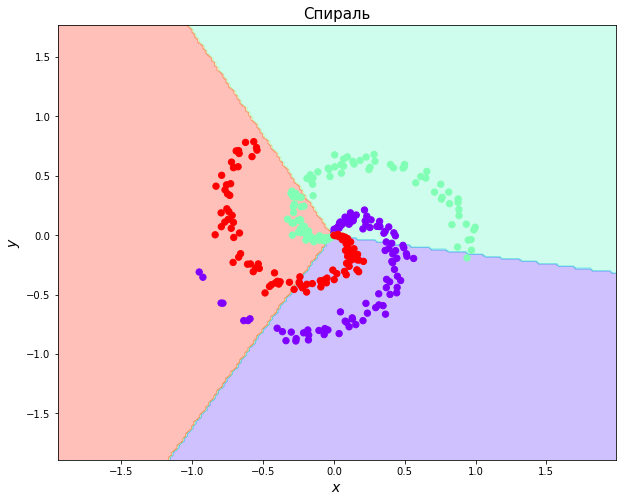

In [18]:
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid_tensor = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

Z = neuron(torch.autograd.Variable(grid_tensor))
Z = Z.data.numpy()
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))

plt.contourf(xx, yy, Z, cmap=plt.cm.rainbow, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.title('Спираль', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

Не слишком впечатляет. В следующей практике мы попробуем многослойную нейросеть на этой же задаче.

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). *Курс Стэнфорда:  http://cs231n.github.io/*  

3). Практически исчерпывающая информация по основам нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/neural-networks-1/,  
http://cs231n.github.io/neural-networks-2/,  
http://cs231n.github.io/neural-networks-3/,  
http://cs231n.github.io/neural-networks-case-study/#linear

4). *Хорошие статьи по основам нейросетей (на английском):  http://neuralnetworksanddeeplearning.com/chap1.html*

5). *Наглядная демонстрация того, как обучаются нейросети:  https://cs.stanford.edu/people/karpathy/convnetjs/*